In [7]:
!nvidia-smi

Mon Oct  9 13:17:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0  On |                  N/A |
|  0%   42C    P2    97W / 370W |   9437MiB / 10240MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import callbacks, optimizers, losses
from keras import backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns
import string
import pandas as pd
import pathlib
from scipy import io as sio

from hvsrUNet.module.hvsr_disp_UNet import HVDP
from hvsrUNet.toolbox.smooth import smooth
%matplotlib inline

In [12]:
path_dir = pathlib.Path('../data/')
cv_list = sio.loadmat(path_dir/'cv_list.mat')['cv_list']
model_list = sio.loadmat(path_dir/'model_list_success.mat')['model_list_success']
fks = sio.loadmat(path_dir/'fks.mat')['fks']
fks = fks.reshape(-1)
hzcum = sio.loadmat(path_dir/'hzcum.mat')['hzcum']
hzcum = hzcum.reshape(-1)

disp = cv_list
hvsr = cv_list
Vs = model_list[:, :512]
hzcum = hzcum[:512]

print(f'cv_list.shape: {cv_list.shape}')
print(f'model_list.shape: {model_list.shape}')
print(f'fks.shape: {fks.shape}')
print(f'hzcum.shape: {hzcum.shape}')
print(f'disp.shape: {disp.shape}')
print(f'Vs.shape: {Vs.shape}')

cv_list.shape: (7623, 512)
model_list.shape: (7623, 1024)
fks.shape: (512,)
hzcum.shape: (512,)
disp.shape: (7623, 512)
Vs.shape: (7623, 512)


In [13]:
disp    = np.expand_dims(disp, axis=-1) / 1000.
hvsr    = np.expand_dims(hvsr, axis=-1) / 1000.
Vs      = np.expand_dims(Vs, axis=-1) / 1000.
data    = np.concatenate((disp, hvsr), axis=-1)

X_train, X_test, y_train, y_test = train_test_split(data, Vs, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


X_train_disp    = tf.expand_dims(X_train[..., :1], axis=2)
X_train_hvsr    = tf.expand_dims(X_train[..., 1:], axis=2)
y_train_disp    = tf.expand_dims(y_train, axis=2)

X_valid_disp    = tf.expand_dims(X_valid[..., :1], axis=2)
X_valid_hvsr    = tf.expand_dims(X_valid[..., 1:], axis=2)
y_valid         = tf.expand_dims(y_valid, axis=2)

X_test_disp     = tf.expand_dims(X_test[..., :1], axis=2)
X_test_hvsr     = tf.expand_dims(X_test[..., 1:], axis=2)
y_test          = tf.expand_dims(y_test, axis=2)


X_train_disp.shape, X_train_hvsr.shape, y_train_disp.shape, X_valid_disp.shape, X_valid_hvsr.shape, y_valid.shape, X_test_disp.shape, X_test_hvsr.shape, y_test.shape

(TensorShape([6174, 512, 1, 1]),
 TensorShape([6174, 512, 1, 1]),
 TensorShape([6174, 512, 1, 1]),
 TensorShape([686, 512, 1, 1]),
 TensorShape([686, 512, 1, 1]),
 TensorShape([686, 512, 1, 1]),
 TensorShape([763, 512, 1, 1]),
 TensorShape([763, 512, 1, 1]),
 TensorShape([763, 512, 1, 1]))

In [4]:
X_train.shape

(4878, 512, 2)

In [14]:
model = HVDP(im_width=1, im_height=512, neurons=8, kern_sz=20,enable_dropout=False)
# model.summary()

In [15]:
yy = model.predict([X_train_disp[:2, ...], X_train_hvsr[:2, ...]])

2023-10-09 15:15:04.143072: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-09 15:15:04.143141: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


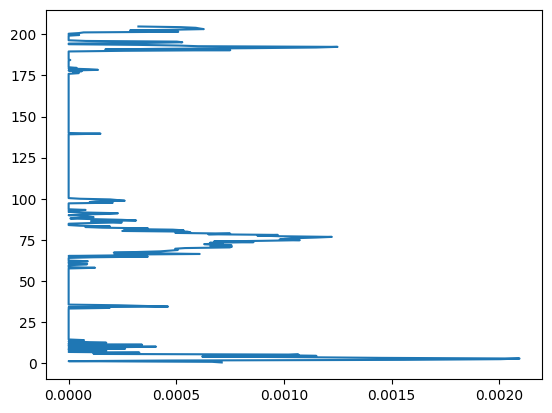

In [16]:
plt.plot(yy[0, :, 0], hzcum)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512, 1)]     0           []                               
                                                                                                  
 Conv_img1 (Conv1D)             (None, 512, 8)       168         ['input_1[0][0]']                
                                                                                                  
 Conv_img2 (Conv1D)             (None, 512, 8)       168         ['input_2[0][0]']                
                                                                                              

In [17]:
name_checkpoint = 'checkpoints/double_2023_10_09/Weights/{epoch:04d}.keras' # 保存模型的路径。
log_dir = 'checkpoints/double_2023_10_09/Logs' # 日志文件保存的目录。
name_csv = 'checkpoints/double_2023_10_09/Logs/disp.csv' # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
lr_val = 0.0001
batch_size = 32
epochs = 1000
n_batches = len(X_train_disp) / batch_size
n_batches = int(np.ceil(n_batches))

def R2_score(v_true, v_pred):
    ssres = K.sum(K.square(v_true - v_pred))
    sstot = K.sum(K.square(v_true - K.mean(v_true)))
    return 1 - ssres / sstot

model_checkpoint = callbacks.ModelCheckpoint(name_checkpoint, # 保存模型的路径。
                                #monitor='val_loss',         # 监控的数据。
                                monitor='val_R2_score',
                                verbose=0,                  # 日志显示模式，0或1。
                                save_best_only=False,       # True，那么最近验证误差最低的模型就不会被覆盖。
                                save_weights_only=False,    # True，那么只有模型的权重会被保存。
                                #mode='auto',                # {auto, min, max}的其中之一。
                                mode='max',
                                save_freq=10*n_batches)               # 'epoch'或整数。保存频率。

early_stopping = callbacks.EarlyStopping(monitor='val_loss', # 监控的数据。
                                min_delta=0,                    # 增大或减小的阈值，只有大于这个部分才算作improvement。
                                patience=100,                     # 没有进步的训练轮数，在这之后训练就会被停止。
                                verbose=0,                      # 日志显示模式，0或1。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                baseline=None,                  # 要监控的数量的基准值，如果模型没有显示出基准的改善，则训练将停止。
                                restore_best_weights=False)     # 是否从具有监视器数量的最佳值的时期恢复模型权重。如果为False，则使用在训练的最后一步获得的模型权重。

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', # 监控的数据。
                                factor=0.5,                     # 触发时将学习率乘以系数的因数。
                                patience=15,                    # 没有进步的训练轮数，在这之后训练速率会被降低。
                                verbose=0,                      # 整数。0：安静，1：更新信息。
                                mode='auto',                    # {auto, min, max}的其中之一。
                                min_delta=0.000001,               # 对于测量新阈值的阈值，只关注巨大的变化。
                                cooldown=0,                     # 在lr被降低之后，训练将在cooldown内的epoch之后继续。
                                min_lr=0)                       # 学习率的下边界。

csv_logger = callbacks.CSVLogger(name_csv, # 将被写入的文件的路径，例如：csv_logger(filename='training.log')。
                                separator=',',              # 用于隔开值的字符串。
                                append=False)               # 如果为True，则将数据添加到现有文件中，而不会重新启动。

optimizer = optimizers.Adam(learning_rate=lr_val)
loss = losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mae', 'mse', R2_score])

history = model.fit([X_train_disp, X_train_hvsr], y_train,
          validation_data=[[X_valid_disp, X_valid_hvsr],y_valid],
                  epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
                   verbose=1)

Epoch 1/1000


2023-10-09 15:16:55.794582: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-09 15:16:55.794634: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-09 15:16:56.348113: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-10-09 15:16:56.348170: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

193/193 [==============================] - 12s 42ms/step - loss: 0.0045 - mae: 0.0406 - mse: 0.0045 - R2_score: -0.1670 - val_loss: 6.7610e-04 - val_mae: 0.0183 - val_mse: 6.7610e-04 - val_R2_score: 0.8276 - lr: 1.0000e-04
Epoch 2/1000
193/193 [==============================] - 6s 33ms/step - loss: 5.2522e-04 - mae: 0.0142 - mse: 5.2522e-04 - R2_score: 0.8635 - val_loss: 4.5088e-04 - val_mae: 0.0126 - val_mse: 4.5088e-04 - val_R2_score: 0.8847 - lr: 1.0000e-04
Epoch 3/1000
193/193 [==============================] - 6s 33ms/step - loss: 4.1326e-04 - mae: 0.0115 - mse: 4.1326e-04 - R2_score: 0.8929 - val_loss: 4.0035e-04 - val_mae: 0.0109 - val_mse: 4.0035e-04 - val_R2_score: 0.8977 - lr: 1.0000e-04
Epoch 4/1000
193/193 [==============================] - 6s 32ms/step - loss: 3.8659e-04 - mae: 0.0111 - mse: 3.8659e-04 - R2_score: 0.8998 - val_loss: 3.7520e-04 - val_mae: 0.0103 - val_mse: 3.7520e-04 - val_R2_score: 0.9041 - lr: 1.0000e-04
Epoch 5/1000
193/193 [=============================

KeyboardInterrupt: 

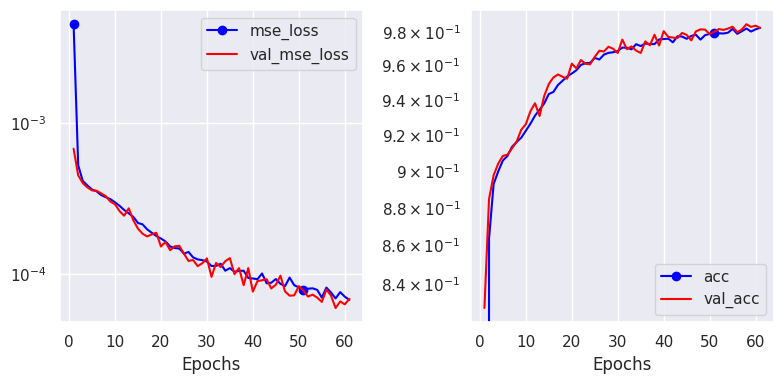

In [18]:
training_log = pd.read_csv('checkpoints/double_2023_10_09/Logs/disp.csv')
training_log.head()

mse_loss = training_log['loss']
val_mse_loss = training_log['val_loss']
acc = training_log['R2_score']
val_acc = training_log['val_R2_score']

accu = {'mse_loss': mse_loss, 
        'val_mse_loss': val_mse_loss,
        'acc': acc,
        'val_acc': val_acc}

value = [mse_loss, val_mse_loss, acc, val_acc]
name = ['mse_loss', 'val_mse_loss', 'acc', 'val_acc']

epochs = range(1, len(acc) + 1)

with plt.style.context('ggplot'):
    sns.set_theme(style='darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for i, ax in enumerate(axes):

        ax.plot(epochs, value[2*i], label=name[2*i], marker='o', color='blue', markevery=50)
        ax.plot(epochs, value[2*i+1], label=name[2*i+1], color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.legend()
        #ax.set_title(name)
    
    plt.tight_layout()

plt.show()
    

In [21]:
model.load_weights('checkpoints/double_2023_10_09/Weights/0050.keras')

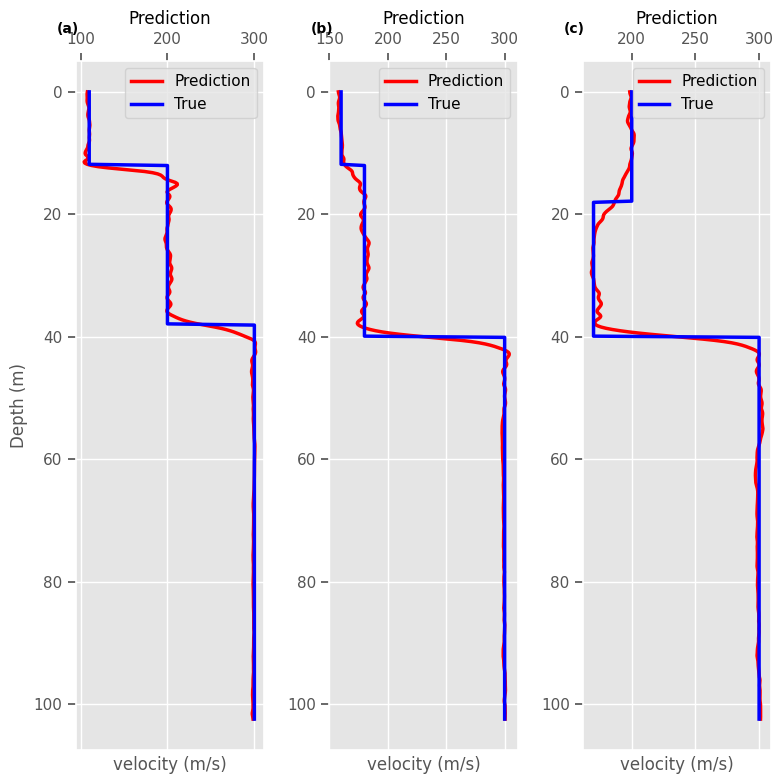

In [28]:
with plt.style.context('ggplot'):
    sns.set_theme(style=None)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    
    for j, ax in enumerate(axes.flat):
        i = np.random.randint(0, 150)
        ypred = model.predict([X_test_disp[i:i+1, ...], X_test_hvsr[i:i+1, ...]])
        yy = smooth(np.squeeze(ypred), window_len=10, window='blackman')
        depth = np.linspace(hzcum.min(), hzcum.max(), len(yy))

        ax.plot(yy*1000, depth, color='red', label='Prediction', linewidth=2.5)
        ax.plot(np.squeeze(y_test[i, ...])*1000, hzcum, color='blue', label='True', linewidth=2.5)
        ax.set_title('Prediction')
        ax.set_xlabel('velocity (m/s)')
        ax.legend()
        ax.text(-0.1, 1.04, '('+string.ascii_lowercase[j]+')', transform=ax.transAxes, size=10, weight='bold')
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    axes[0].set_ylabel('Depth (m)')
    fig.tight_layout()
    plt.show()